# Student Simulation and Analysis

This notebook demonstrates the generation and analysis of 100 simulated student profiles for the AI academic advising system.

## Overview
- **Student Generation**: Create diverse student profiles with realistic academic histories
- **Cohort Analysis**: Statistical analysis of the student population
- **Individual Profiles**: Deep dive into specific student cases
- **Recommendation Scenarios**: Test course recommendation scenarios
- **Performance Metrics**: Evaluate student success patterns

## Statistical Distributions Used in Student Simulation

The student data generation process uses several statistical distributions to create realistic and diverse student profiles:

### 📊 **Grade Simulation**
- **Distribution**: Normal Distribution
- **Parameters**: 
  - Mean varies by course difficulty: Beginner (3.2), Intermediate (2.9), Advanced (2.7)
  - Standard deviation varies by difficulty: Beginner (0.6), Intermediate (0.8), Advanced (0.9)
- **Adjustments**: 
  - Interest boost: ±0.8 based on student's domain interest (0-1 scale)
  - Ability boost: ±1.0 based on student's inherent ability (0-1 scale)
- **Range**: Clamped to valid GPA range [0.0, 4.0]

### 🎯 **Student Interests**
- **Distribution**: Uniform Distribution
- **Primary interests**: 1-3 domains per student with interest level [0.7, 1.0]
- **Secondary interests**: Remaining domains with interest level [0.1, 0.5]
- **Domains**: AI, Security, Data Science, Software Engineering, Systems, Theory

### 🧠 **Student Ability**
- **Distribution**: Beta Distribution with parameters α=2, β=2
- **Shape**: Bell-shaped, centered around 0.5
- **Range**: [0, 1] representing inherent academic ability
- **Effect**: Influences grade performance across all courses

### 📚 **Course Selection**
- **Distribution**: Weighted selection based on interest scores
- **Factors**: Domain interest + term appropriateness + random variation
- **Constraints**: Prerequisites must be satisfied, failed courses excluded

### 🎓 **Academic Progression**
- **Terms**: Variable progression (1-8 terms) with 10% early stop probability after term 4
- **Courses per term**: Random integer [3, 5] courses
- **Failure threshold**: Grades below 2.0 are considered failed

These distributions ensure realistic diversity in student profiles while maintaining academic constraints and logical progression patterns.

In [1]:
# Import Required Libraries
import sys
import os
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Project modules
from src.curriculum_graph import create_sample_curriculum
from src.student_simulation import StudentSimulator, create_student_cohort
from src.constraints import create_constraint_validator
from src.visualization import create_visualizer

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)  # For reproducible results

print("✓ Libraries imported successfully")
print("✓ Random seed set for reproducibility")

✓ Libraries imported successfully
✓ Random seed set for reproducibility


In [2]:
# Generate Student Cohort
print("Generating AI Curriculum Planner components...")

# Initialize system
curriculum = create_sample_curriculum()
simulator = StudentSimulator(curriculum)

print(f"✓ Curriculum loaded with {len(curriculum.graph.nodes())} courses")

# Generate 100 diverse students
print("Generating 100 student profiles...")
students = simulator.generate_cohort(100)

print(f"✓ Generated {len(students)} student profiles")

# Get cohort statistics
stats = simulator.get_cohort_statistics(students)

print("\n" + "="*60)
print("STUDENT COHORT OVERVIEW")
print("="*60)
print(f"Total Students: {stats['total_students']}")
print(f"\n📊 GPA STATISTICS")
print(f"  Mean GPA: {stats['gpa_stats']['mean']:.2f}")
print(f"  GPA Range: {stats['gpa_stats']['min']:.2f} - {stats['gpa_stats']['max']:.2f}")
print(f"  GPA Std Dev: {stats['gpa_stats']['std']:.2f}")

print(f"\n📚 ACADEMIC PROGRESS")
print(f"  Average Courses Completed: {stats['courses_completed']['mean']:.1f}")
print(f"  Range: {stats['courses_completed']['min']} - {stats['courses_completed']['max']} courses")
print(f"  Average Current Term: {stats['term_stats']['mean']:.1f}")

print(f"\n🎯 ACADEMIC STANDING")
for standing, count in stats['academic_standing'].items():
    percentage = (count / stats['total_students']) * 100
    print(f"  {standing}: {count} students ({percentage:.1f}%)")

print(f"\n🏆 INTEREST DISTRIBUTION")
for domain, info in stats['interest_distribution'].items():
    print(f"  {domain}:")
    print(f"    Average Interest: {info['mean']:.2f}")
    print(f"    High Interest Students: {info['high_interest_students']}")

print("\n✓ Cohort generation and analysis complete!")

Generating AI Curriculum Planner components...
✓ Curriculum loaded with 34 courses
Generating 100 student profiles...
✓ Generated 100 student profiles

STUDENT COHORT OVERVIEW
Total Students: 100

📊 GPA STATISTICS
  Mean GPA: 3.12
  GPA Range: 2.53 - 4.00
  GPA Std Dev: 0.25

📚 ACADEMIC PROGRESS
  Average Courses Completed: 20.1
  Range: 2 - 33 courses
  Average Current Term: 6.2

🎯 ACADEMIC STANDING
  Good: 29 students (29.0%)
  Probation: 0 students (0.0%)

🏆 INTEREST DISTRIBUTION
  AI:
    Average Interest: 0.48
    High Interest Students: 32
  Security:
    Average Interest: 0.51
    High Interest Students: 38
  Data Science:
    Average Interest: 0.50
    High Interest Students: 37
  Software Engineering:
    Average Interest: 0.48
    High Interest Students: 31
  Systems:
    Average Interest: 0.51
    High Interest Students: 35
  Theory:
    Average Interest: 0.45
    High Interest Students: 31

✓ Cohort generation and analysis complete!


## 1. Student Cohort Visualization

Let's visualize the characteristics of our simulated student population to understand the diversity and realism of the generated profiles.

In [3]:
# Create comprehensive student cohort visualizations
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=['GPA Distribution', 'Academic Standing Distribution', 
                   'Courses Completed Distribution', 'Current Term Distribution',
                   'Interest Distribution by Domain', 'GPA vs Courses Completed'],
    specs=[[{"type": "histogram"}, {"type": "pie"}],
           [{"type": "histogram"}, {"type": "histogram"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# 1. GPA Distribution
gpas = [s.gpa for s in students]
fig.add_trace(go.Histogram(
    x=gpas, nbinsx=20, name="GPA Distribution", 
    marker_color='lightblue', showlegend=False
), row=1, col=1)

# 2. Academic Standing Distribution
standing_counts = {}
for s in students:
    standing_counts[s.academic_standing] = standing_counts.get(s.academic_standing, 0) + 1

fig.add_trace(go.Pie(
    labels=list(standing_counts.keys()), 
    values=list(standing_counts.values()),
    name="Academic Standing", showlegend=False
), row=1, col=2)

# 3. Courses Completed Distribution
courses_completed = [len(s.completed_courses) for s in students]
fig.add_trace(go.Histogram(
    x=courses_completed, nbinsx=15, name="Courses Completed",
    marker_color='lightgreen', showlegend=False
), row=2, col=1)

# 4. Current Term Distribution
current_terms = [s.current_term for s in students]
fig.add_trace(go.Histogram(
    x=current_terms, nbinsx=10, name="Current Term",
    marker_color='lightcoral', showlegend=False
), row=2, col=2)

# 5. Interest Distribution by Domain
domains = ['AI', 'Security', 'Data Science', 'Software Engineering', 'Systems', 'Theory']
avg_interests = []
for domain in domains:
    avg_interest = np.mean([s.interests.get(domain, 0) for s in students])
    avg_interests.append(avg_interest)

fig.add_trace(go.Bar(
    x=domains, y=avg_interests, name="Average Interest",
    marker_color='gold', showlegend=False
), row=3, col=1)

# 6. GPA vs Courses Completed Scatter
fig.add_trace(go.Scatter(
    x=courses_completed, y=gpas, mode='markers',
    marker=dict(color='purple', size=8, opacity=0.6),
    name="GPA vs Courses", showlegend=False
), row=3, col=2)

# Update layout
fig.update_layout(
    title_text="Student Cohort Analysis Dashboard",
    height=1000,
    showlegend=False
)

# Update x-axis labels
fig.update_xaxes(title_text="GPA", row=1, col=1)
fig.update_xaxes(title_text="Number of Courses", row=2, col=1)
fig.update_xaxes(title_text="Term Number", row=2, col=2)
fig.update_xaxes(title_text="Academic Domain", row=3, col=1)
fig.update_xaxes(title_text="Courses Completed", row=3, col=2)

# Update y-axis labels
fig.update_yaxes(title_text="Number of Students", row=1, col=1)
fig.update_yaxes(title_text="Number of Students", row=2, col=1)
fig.update_yaxes(title_text="Number of Students", row=2, col=2)
fig.update_yaxes(title_text="Average Interest Level", row=3, col=1)
fig.update_yaxes(title_text="GPA", row=3, col=2)

fig.show()

print("📊 Cohort visualization complete!")
print(f"   - Generated visualizations for {len(students)} students")
print(f"   - GPA range: {min(gpas):.2f} - {max(gpas):.2f}")
print(f"   - Course completion range: {min(courses_completed)} - {max(courses_completed)}")

📊 Cohort visualization complete!
   - Generated visualizations for 100 students
   - GPA range: 2.53 - 4.00
   - Course completion range: 2 - 33


## 2. Statistical Distributions Used in Student Generation

This section documents the statistical models and distributions used to create realistic student profiles.

### 2.1 Grade Distribution Model
The grade simulation uses **domain-specific normal distributions** based on course difficulty and student interest:

- **Base Grade Means** (by difficulty):
  - Beginner: μ = 3.2, σ = 0.6 
  - Intermediate: μ = 2.9, σ = 0.8
  - Advanced: μ = 2.7, σ = 0.9

- **Interest Adjustment**: ±0.8 points based on student's domain interest level
- **Student Ability**: Beta(2,2) distribution for individual variation

### 2.2 Student Interest Generation
- **Primary Interests**: Each student has 1-3 domains with high interest (0.7-1.0)
- **Secondary Interests**: Remaining domains have moderate interest (0.1-0.5)
- **Distribution**: Uniform sampling within specified ranges

📈 STATISTICAL ANALYSIS OF GENERATED STUDENT POPULATION

🎯 GPA DISTRIBUTION
  Mean: 3.118
  Median: 3.115
  Standard Deviation: 0.254
  Skewness: 1.009
  Range: [2.53, 4.00]

🏆 INTEREST DISTRIBUTION ANALYSIS
  AI:
    Mean Interest: 0.483
    Std Dev: 0.281
    High Interest (>0.7): 32 students (32.0%)
  Security:
    Mean Interest: 0.505
    Std Dev: 0.276
    High Interest (>0.7): 38 students (38.0%)
  Data Science:
    Mean Interest: 0.504
    Std Dev: 0.295
    High Interest (>0.7): 37 students (37.0%)
  Software Engineering:
    Mean Interest: 0.476
    Std Dev: 0.268
    High Interest (>0.7): 31 students (31.0%)
  Systems:
    Mean Interest: 0.505
    Std Dev: 0.270
    High Interest (>0.7): 35 students (35.0%)
  Theory:
    Mean Interest: 0.450
    Std Dev: 0.291
    High Interest (>0.7): 31 students (31.0%)

📚 ACADEMIC PROGRESS ANALYSIS
  Courses Completed:
    Mean: 20.1
    Std Dev: 8.8
    Range: [2, 33]
  Current Term:
    Mean: 6.2
    Mode: 8
    Range: [2, 8]

🎓 ACADEMIC 

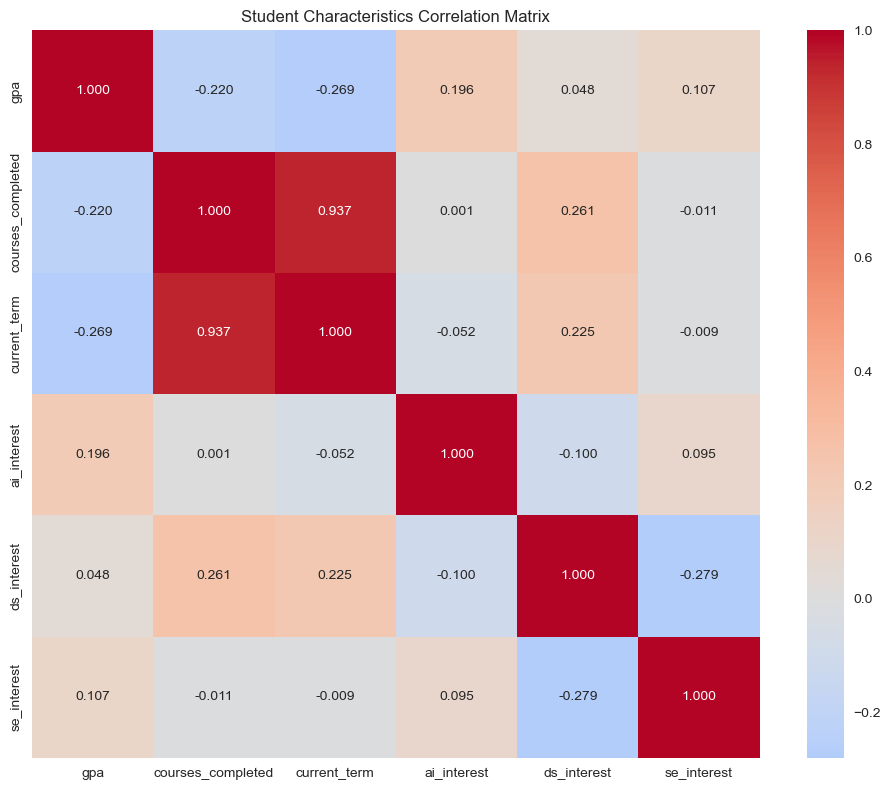


✓ Statistical analysis complete!


In [4]:
# Analyze the statistical distributions in our generated cohort
print("📈 STATISTICAL ANALYSIS OF GENERATED STUDENT POPULATION")
print("=" * 70)

# 1. GPA Distribution Analysis
gpas = np.array([s.gpa for s in students])
print(f"\n🎯 GPA DISTRIBUTION")
print(f"  Mean: {np.mean(gpas):.3f}")
print(f"  Median: {np.median(gpas):.3f}")
print(f"  Standard Deviation: {np.std(gpas):.3f}")
print(f"  Skewness: {pd.Series(gpas).skew():.3f}")
print(f"  Range: [{np.min(gpas):.2f}, {np.max(gpas):.2f}]")

# 2. Interest Distribution Analysis
print(f"\n🏆 INTEREST DISTRIBUTION ANALYSIS")
for domain in domains:
    interests = [s.interests.get(domain, 0) for s in students]
    high_interest = sum(1 for x in interests if x > 0.7)
    print(f"  {domain}:")
    print(f"    Mean Interest: {np.mean(interests):.3f}")
    print(f"    Std Dev: {np.std(interests):.3f}")
    print(f"    High Interest (>0.7): {high_interest} students ({high_interest/len(students)*100:.1f}%)")

# 3. Academic Progress Distribution
courses_completed = [len(s.completed_courses) for s in students]
current_terms = [s.current_term for s in students]

print(f"\n📚 ACADEMIC PROGRESS ANALYSIS")
print(f"  Courses Completed:")
print(f"    Mean: {np.mean(courses_completed):.1f}")
print(f"    Std Dev: {np.std(courses_completed):.1f}")
print(f"    Range: [{min(courses_completed)}, {max(courses_completed)}]")

print(f"  Current Term:")
print(f"    Mean: {np.mean(current_terms):.1f}")
print(f"    Mode: {pd.Series(current_terms).mode().iloc[0]}")
print(f"    Range: [{min(current_terms)}, {max(current_terms)}]")

# 4. Academic Standing Distribution
standing_dist = {}
for s in students:
    standing_dist[s.academic_standing] = standing_dist.get(s.academic_standing, 0) + 1

print(f"\n🎓 ACADEMIC STANDING DISTRIBUTION")
for standing, count in standing_dist.items():
    percentage = (count / len(students)) * 100
    print(f"  {standing}: {count} students ({percentage:.1f}%)")

# 5. Correlation Analysis
print(f"\n🔗 CORRELATION ANALYSIS")
# Create correlation matrix
correlation_data = []
for student in students:
    correlation_data.append({
        'gpa': student.gpa,
        'courses_completed': len(student.completed_courses),
        'current_term': student.current_term,
        'ai_interest': student.interests.get('AI', 0),
        'ds_interest': student.interests.get('Data Science', 0),
        'se_interest': student.interests.get('Software Engineering', 0)
    })

corr_df = pd.DataFrame(correlation_data)
correlation_matrix = corr_df.corr()

print("Correlation Matrix (key relationships):")
print(f"  GPA vs Courses Completed: {correlation_matrix.loc['gpa', 'courses_completed']:.3f}")
print(f"  GPA vs Current Term: {correlation_matrix.loc['gpa', 'current_term']:.3f}")
print(f"  AI Interest vs Data Science Interest: {correlation_matrix.loc['ai_interest', 'ds_interest']:.3f}")

# Display correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Student Characteristics Correlation Matrix')
plt.tight_layout()
plt.show()

print("\n✓ Statistical analysis complete!")

## 3. Individual Student Profile Analysis

Let's examine specific student profiles to understand the diversity and realism of our simulation.

In [5]:
# Analyze individual student profiles to showcase diversity
def analyze_student_profile(student, curriculum):
    """Detailed analysis of a single student profile"""
    print(f"👤 STUDENT PROFILE: {student.student_id}")
    print("=" * 50)
    
    # Basic info
    print(f"Name: {student.name}")
    print(f"GPA: {student.gpa:.2f}")
    print(f"Current Term: {student.current_term}")
    print(f"Academic Standing: {student.academic_standing}")
    print(f"Target Graduation: Term {student.target_graduation_term}")
    
    # Academic progress
    passed_courses = [c for c, g in student.completed_courses.items() if g >= 2.0]
    failed_courses = [c for c, g in student.completed_courses.items() if g < 2.0]
    
    credits_completed = sum(
        curriculum.get_course_info(course).get('credits', 3)
        for course in passed_courses
    )
    
    print(f"\n📚 ACADEMIC PROGRESS")
    print(f"  Courses Passed: {len(passed_courses)}")
    print(f"  Courses Failed: {len(failed_courses)}")
    print(f"  Credits Completed: {credits_completed}")
    print(f"  Progress to Graduation: {credits_completed/120*100:.1f}%")
    
    # Interest analysis
    sorted_interests = sorted(student.interests.items(), key=lambda x: x[1], reverse=True)
    print(f"\n🎯 INTEREST PROFILE")
    for domain, interest in sorted_interests:
        print(f"  {domain}: {interest:.2f}")
    
    # Course history by domain
    domain_performance = {}
    for course, grade in student.completed_courses.items():
        if grade >= 2.0:  # Only passed courses
            course_info = curriculum.get_course_info(course)
            domain = course_info.get('domain', 'Other')
            if domain not in domain_performance:
                domain_performance[domain] = []
            domain_performance[domain].append(grade)
    
    print(f"\n📊 PERFORMANCE BY DOMAIN")
    for domain, grades in domain_performance.items():
        if grades:
            avg_grade = np.mean(grades)
            print(f"  {domain}: {avg_grade:.2f} avg ({len(grades)} courses)")
    
    # Show some completed courses
    print(f"\n📋 SAMPLE COMPLETED COURSES")
    sample_courses = list(student.completed_courses.items())[:8]
    for course, grade in sample_courses:
        course_info = curriculum.get_course_info(course)
        status = "✓" if grade >= 2.0 else "✗"
        print(f"  {status} {course}: {course_info.get('name', 'Unknown')} (Grade: {grade:.1f})")
    
    if len(student.completed_courses) > 8:
        print(f"  ... and {len(student.completed_courses) - 8} more courses")
    
    return student

# Analyze diverse student profiles
print("🔍 INDIVIDUAL STUDENT ANALYSIS")
print("Selecting diverse students for detailed analysis...\n")

# Select students with different characteristics
diverse_students = []

# High performer
high_gpa_students = [s for s in students if s.gpa >= 3.5]
if high_gpa_students:
    diverse_students.append(("High Performer", high_gpa_students[0]))

# Struggling student
low_gpa_students = [s for s in students if s.gpa <= 2.5]
if low_gpa_students:
    diverse_students.append(("Struggling Student", low_gpa_students[0]))

# AI-focused student
ai_students = [s for s in students if s.interests.get('AI', 0) > 0.8]
if ai_students:
    diverse_students.append(("AI Specialist", ai_students[0]))

# Early-term student
early_students = [s for s in students if s.current_term <= 3]
if early_students:
    diverse_students.append(("Early Career", early_students[0]))

# Advanced student
advanced_students = [s for s in students if s.current_term >= 7]
if advanced_students:
    diverse_students.append(("Advanced Student", advanced_students[0]))

# Analyze each selected student
for category, student in diverse_students:
    print(f"\n{'='*60}")
    print(f"CATEGORY: {category}")
    print(f"{'='*60}")
    analyze_student_profile(student, curriculum)

print(f"\n✓ Analyzed {len(diverse_students)} diverse student profiles")

🔍 INDIVIDUAL STUDENT ANALYSIS
Selecting diverse students for detailed analysis...


CATEGORY: High Performer
👤 STUDENT PROFILE: STU_010
Name: Student_010
GPA: 4.00
Current Term: 2
Academic Standing: Good
Target Graduation: Term 12

📚 ACADEMIC PROGRESS
  Courses Passed: 1
  Courses Failed: 1
  Credits Completed: 3
  Progress to Graduation: 2.5%

🎯 INTEREST PROFILE
  Systems: 0.87
  AI: 0.87
  Data Science: 0.86
  Software Engineering: 0.49
  Theory: 0.20
  Security: 0.12

📊 PERFORMANCE BY DOMAIN
  Software Engineering: 4.00 avg (1 courses)

📋 SAMPLE COMPLETED COURSES
  ✓ CS101: Intro to Programming (Grade: 4.0)
  ✗ MATH101: Discrete Mathematics (Grade: 1.5)

CATEGORY: AI Specialist
👤 STUDENT PROFILE: STU_005
Name: Student_005
GPA: 3.28
Current Term: 4
Academic Standing: Good
Target Graduation: Term 11

📚 ACADEMIC PROGRESS
  Courses Passed: 13
  Courses Failed: 1
  Credits Completed: 39
  Progress to Graduation: 32.5%

🎯 INTEREST PROFILE
  AI: 0.99
  Security: 0.84
  Theory: 0.39
  Data 